# Visualization DecoupleR results

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt

## Follow Pseudobulk.ipynb tutorial

In [2]:
adata = sc.read_h5ad("E-MTAB-9221/E-MTAB-9221.h5ad")
adata

AnnData object with n_obs × n_vars = 6807 × 20522
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[clinical history]', 'Sample Characteristic Ontology Term[clinical history]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Factor Value[disease]', 'Factor Value Ontology Term[disease]', 'Factor Value[clinical history]', 'Factor Value Ontology Term[clinical history]', 'Factor Value[sampling time point]', 'Factor Value Ontology Term[sampling time point]', 'Fact

In [3]:
# Rename meta-data
columns = ['Sample Characteristic[sex]',
           'Sample Characteristic[individual]',
           'Sample Characteristic[disease]',
           'Factor Value[inferred cell type - ontology labels]']
adata.obs = adata.obs[columns]
adata.obs.columns = ['sex','individual','disease','cell_type']
# Retrieve gene symbols
annot = sc.queries.biomart_annotations("hsapiens",
        ["ensembl_gene_id", "external_gene_name"],
        use_cache=True
    ).set_index("ensembl_gene_id")

# Filter genes not in annotation
adata = adata[:, adata.var.index.intersection(annot.index)]

# Assign gene symbols
adata.var['gene_symbol'] = [annot.loc[ensembl_id,'external_gene_name'] for ensembl_id in adata.var.index]
adata.var = adata.var.reset_index().rename(columns={'index': 'ensembl_gene_id'}).set_index('gene_symbol')

# Remove genes with no gene symbol
adata = adata[:, ~pd.isnull(adata.var.index)]

# Remove duplicates
adata.var_names_make_unique()

# Remove non-annotated cells
adata = adata[~adata.obs['cell_type'].isnull()]

# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['normalized'] = adata.X

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual')

# Scale the data
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata)

# Generate UMAP features
sc.tl.umap(adata)

# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)

pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)

/tmp/ipykernel_91008/991214121.py:18: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_symbol'] = [annot.loc[ensembl_id,'external_gene_name'] for ensembl_id in adata.var.index]
/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_91008/991214121.py:32: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X
/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True t

In [4]:
dc.get_metadata_associations(
    pp_pdata,
    obs_keys = ['sex', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'], #metadata columns to associate to PCs
    obsm_key='X_pca',  # where the PCs are stored
    uns_key='pca_anova',  # where the results are stored
    inplace=True
)

  0%|                                                                                                           | 0/10 [00:00<?, ?it/s]/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/decoupler/utils_anndata.py:1093: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row = [explainer, aov_table['PR(>F)'][0], eta_sq]
/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/decoupler/utils_anndata.py:1093: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row = [explainer, aov_table['PR(>F)'][0], eta_sq]
/lustre/scratch126/cellgen/team205/sl37/conda_envs/ha

/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/matplotlib/lines.py:1205: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


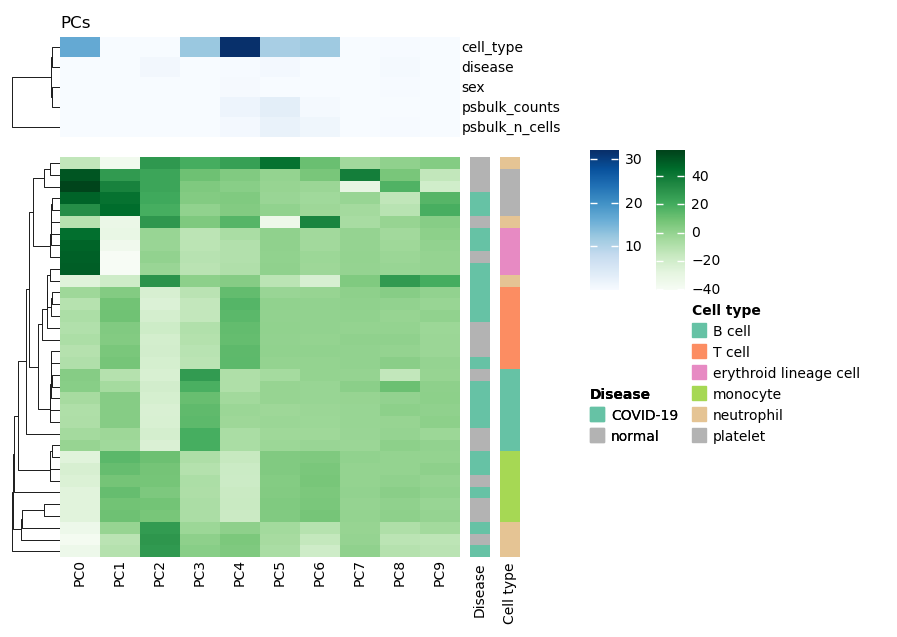

In [5]:
# pp_pdata = sc.read_h5ad("problem_plot.h5ad")
pvals_df = pp_pdata.uns['pca_anova'].pivot(index='variable', columns='factor', values='p_adj').dropna()
neglog_p_df = pd.DataFrame(data=-np.log10(pvals_df.values),
                           index=list(pvals_df.index),
                           columns=list(pvals_df.columns))
pcs_df = pd.DataFrame(data=pp_pdata.obsm['X_pca'],
                      columns=[f'PC{ind}' for ind in range(10)],
                      index=pp_pdata.obs.index).reset_index().drop('index', axis=1)

import marsilea as ma
import marsilea.plotter as mp
from marsilea.plotter import MarkerMesh

h1 = ma.Heatmap(neglog_p_df, cmap="Blues", width=4, height=1, name="h1")
h1.add_title(top="PCs", align="left")
h1.add_legends()
h1.add_dendrogram("left")
h1.add_right(mp.Labels(neglog_p_df.index, fontsize=10))

h2 = ma.Heatmap(pcs_df.values, cmap="Greens", width=0.4, height=4, name="h2")
h2.add_legends()
h2.add_dendrogram("left")

disease_cat = list(pp_pdata.obs['disease'].values)
disease_colors = mp.Colors(disease_cat, cmap="Set2", label="Disease")

celltype_cat = list(pp_pdata.obs['cell_type'].values)
celltype_colors = mp.Colors(celltype_cat, cmap="Set2", label="Cell type")


h2.add_right(disease_colors, pad=0.1, size=0.2)
h2.add_right(celltype_colors, pad=0.1, size=0.2)
h2.add_bottom(mp.Labels(pcs_df.columns, fontsize=10))

c = (h1 / .2 / h2)
c.add_legends(side="right",
              stack_by='row', stack_size=2)
c.render()

### DE analysis

In [7]:
# Select T cell profiles
tcells = pdata[pdata.obs['cell_type'] == 'T cell'].copy()
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(tcells, group='disease', min_count=10, min_total_count=15)
# Filter by these genes
tcells = tcells[:, genes].copy()
tcells

AnnData object with n_obs × n_vars = 7 × 10415
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

In [9]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
# Build DESeq2 object

dds = DeseqDataSet(
    adata=tcells,
    design_factors='disease',
    ref_level=['disease', 'normal'],
    refit_cooks=True,
)
# Compute LFCs
dds.deseq2()
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(dds, contrast=["disease", 'COVID-19', 'normal'])
# Compute Wald test
stat_res.summary()
# Shrink LFCs
stat_res.lfc_shrink(coeff='disease_COVID-19_vs_normal')
# Extract results
results_df = stat_res.results_df
mat = results_df[['stat']].T.rename(index={'stat': 'T cell'})

Running Wald tests...
... done in 5.63 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: disease COVID-19 vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                             
A1BG          70.471703       -0.162066  0.141199 -1.147785  0.251057   
A2M           36.735027       -1.259308  0.327191 -3.848842  0.000119   
A2MP1         15.628274        0.615852  0.766822  0.803122  0.421904   
AAAS          18.305878        0.233859  0.363536  0.643290  0.520036   
AACS          24.630203        0.216562  0.218214  0.992428  0.320989   
...                 ...             ...       ...       ...       ...   
ZXDC          30.181501       -0.298363  0.344888 -0.865103  0.386982   
ZYG11B       101.884621        0.271063  0.302902  0.894887  0.370847   
ZYX           81.599907        0.299973  0.240366  1.247984  0.212037   
ZZEF1        820.790100        0.028608  0.233583  0.122474  0.902523   
ZZZ3          59.928497       -0.071308  0.287022 -0.248439

... done in 19.36 seconds.



In [35]:
def run_deseq(adat, celltype):
    dds = DeseqDataSet(
        adata=adat,
        design_factors='disease',
        ref_level=['disease', 'normal'],
        refit_cooks=True,
    )
    # Compute LFCs
    dds.deseq2()
    # Extract contrast between COVID-19 vs normal
    stat_res = DeseqStats(dds, contrast=["disease", 'COVID-19', 'normal'])
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff='disease_COVID-19_vs_normal')
    # Extract results
    results_df = stat_res.results_df
    mat = results_df[['stat']].T.rename(index={'stat': celltype})
    return mat, results_df

# Select T cell profiles
monocytes = pdata[pdata.obs['cell_type'] == 'monocyte'].copy()
# Obtain genes that pass the thresholds
mono_genes = dc.filter_by_expr(monocytes, group='disease', min_count=10, min_total_count=15)
monocytes = monocytes[:, mono_genes].copy()
monocytes_mat, monocytes_results_df = run_deseq(monocytes, 'monocyte')

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 58.30 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 48.32 seconds.

Fitting LFCs...
... done in 7.74 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 4.47 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: disease COVID-19 vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                             
A1BG          34.143665       -0.167697  0.288158 -0.581962  0.560592   
AACS           8.592971       -0.081786  0.623640 -0.131143  0.895662   
AAGAB         23.659803       -0.191046  0.433204 -0.441007  0.659208   
AAK1         120.881950        0.158233  0.159201  0.993925  0.320260   
AAMDC          9.092721       -0.260456  0.562932 -0.462678  0.643596   
...                 ...             ...       ...       ...       ...   
ZSWIM8        23.799789        0.506783  0.300365  1.687224  0.091560   
ZXDC          19.237398       -0.036585  0.311928 -0.117287  0.906633   
ZYG11B        43.960163        0.194547  0.192817  1.008973  0.312988   
ZYX          151.810471        0.438666  0.158342  2.770378  0.005599   
ZZEF1        311.208832       -0.140393  0.280033 -0.501344

... done in 16.40 seconds.



In [20]:
mat.shape, monocytes_mat.shape

((1, 10415), (1, 8275))

In [36]:
mat.to_csv("Tcell_deseq_results.csv")
results_df.to_csv("Tcell_deseq_full_results.csv")

monocytes_mat.to_csv("Monocytes_deseq_results.csv")
monocytes_results_df.to_csv("Monocytes_deseq_full_results.csv")

### Gene set enrichment analysis

In [4]:
# load DE results from previous section
mat = pd.read_csv("Tcell_deseq_results.csv", index_col=0)
results_df = pd.read_csv("Tcell_deseq_full_results.csv", index_col=0)

monocytes_mat = pd.read_csv("Monocytes_deseq_results.csv", index_col=0)
monocytes_results_df = pd.read_csv("Monocytes_deseq_full_results.csv", index_col=0)

In [6]:
# download database for enrichment analysis
collectri = dc.get_collectri(organism='human', split_complexes=False)
progeny = dc.get_progeny(top=500)
msigdb = dc.get_resource('MSigDB')
msigdb = msigdb[msigdb['collection']=='hallmark']
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/omnipath/_core/downloader/_downloader.py", line 143, in maybe_download
    res = self._download(req)
  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/omnipath/_core/downloader/_downloader.py", line 181, in _download
    resp.raise_for_status()
  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/requests/models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 500 Server Error: Internal Server Error for url: https://omnipathdb.org/queries/enzsub?format=json

  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/omnipath/_core/downloader/_downloader.py", line 143, in maybe_download
    res = self._download(req)
  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9

0.00B [00:00, ?B/s]

  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/urllib3/response.py", line 710, in _error_catcher
    yield
  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/urllib3/response.py", line 1076, in read_chunked
    chunk = self._handle_chunk(amt)
  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages/urllib3/response.py", line 1018, in _handle_chunk
    value = self._fp._safe_read(amt)  # type: ignore[union-attr]
  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/http/client.py", line 628, in _safe_read
    raise IncompleteRead(b''.join(s), amt)
http.client.IncompleteRead: IncompleteRead(5435 bytes read, 2761 more expected)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/lustre/scratch126/cellgen/team205/sl37/conda_envs/hackathon/lib/python3.9/site-packages

In [31]:
def gene_enrichment_results(mat, results_df):
    tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
    tf_df = pd.concat([tf_acts.T.rename({tf_acts.index[0]: 'stats'}, axis=1), 
                       tf_pvals.T.rename({tf_pvals.index[0]: 'pval'}, axis=1)], 
                      axis=1)
    pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
    pathway_df = pd.concat([pathway_acts.T.rename({pathway_acts.index[0]: 'stats'}, axis=1),
                            pathway_pvals.T.rename({pathway_pvals.index[0]: 'pval'}, axis=1)],
                           axis=1)
    top_genes = results_df[results_df['padj'] < 0.05]
    enr_pvals = dc.get_ora_df(
        df=top_genes,
        net=msigdb,
        source='geneset',
        target='genesymbol'
    ).rename({'FDR p-value': 'pval',
              'Odds ratio': 'stats'}, axis=1).set_index('Term')
    return {'TF':tf_df, 
            'pathway':pathway_df, 
            'gsea':enr_pvals[['pval', 'stats']]}

In [34]:
monocyte_res_dic = gene_enrichment_results(
    monocytes_mat,
    monocytes_results_df
)
tcell_res_dic = gene_enrichment_results(
    mat,
    results_df
)

## Visualize enrichment results 

### bar plots

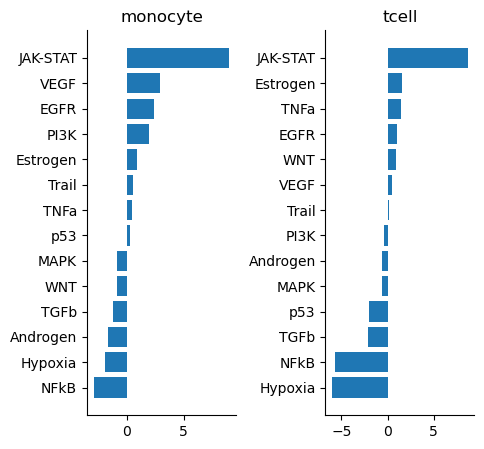

In [122]:
import seaborn as sns
db_name = 'pathway'
show_term_numbers = 20

monocyte_barplot_df = pd.concat([monocyte_res_dic[db_name]['stats'].sort_values().head(int(show_term_numbers/2)),
                monocyte_res_dic[db_name]['stats'].sort_values().tail(int(show_term_numbers/2))], 
               axis=0).to_frame().reset_index().rename({'index': db_name}, axis=1)
monocyte_barplot_df['celltype'] = 'monocyte'
tcell_barplot_df = pd.concat([tcell_res_dic[db_name]['stats'].sort_values().head(int(show_term_numbers/2)),
                tcell_res_dic[db_name]['stats'].sort_values().tail(int(show_term_numbers/2))], 
               axis=0).to_frame().reset_index().rename({'index': db_name}, axis=1)
tcell_barplot_df['celltype'] = 'tcell'

df = pd.concat([monocyte_barplot_df, tcell_barplot_df], axis=0)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(5, 5), gridspec_kw={'wspace':0.6})
ax1, ax2 = axes
for i, celltype in enumerate(list(df['celltype'].unique())):
    axes[i].barh(y=df['pathway'][df['celltype'] == celltype],
                 width=df['stats'][df['celltype'] == celltype],
                )
    axes[i].set_title(celltype)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

### Volcano plots for targets

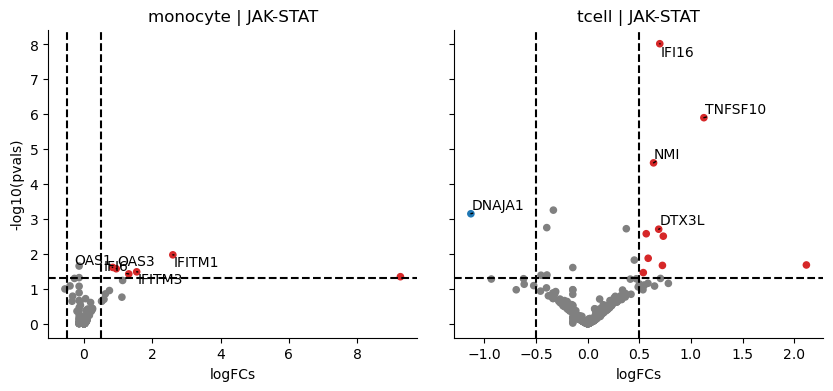

In [173]:
source_name = 'JAK-STAT'
db_name = 'pathway'

def get_targets_de_df(de_results_df, db_source_df):
    db_targets = db_source_df[db_source_df['source'] == source_name]['target'].values
    targets = list(set(de_results_df.index) & set(db_targets))
    targets_de_df = de_results_df.loc[targets]
    return targets_de_df

targets_de_dic = {}
targets_de_dic['monocyte'] = get_targets_de_df(monocytes_results_df, progeny)
targets_de_dic['tcell'] = get_targets_de_df(results_df, progeny)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw={'wspace':0.1})
ax1, ax2 = axes
for i, celltype in enumerate(list(df['celltype'].unique())):
    dc.plot_volcano_df(targets_de_dic[celltype], 
                       x='log2FoldChange', 
                       y='padj', 
                       top=5, 
                       ax=axes[i])
    axes[i].set_title(f'{celltype} | {source_name}')
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)

In [190]:
progeny_dic = progeny.set_index("target")['source'].T.to_dict()
merged_de_results_df = pd.concat([results_df[['log2FoldChange', 'padj']].add_suffix('_tcell'),
           monocytes_results_df[['log2FoldChange', 'padj']].add_suffix('_monocyte')], axis=1)
merged_de_results_df['source'] = [progeny_dic.get(x) for x in merged_de_results_df.index]

In [201]:
merged_de_results_df = merged_de_results_df[~merged_de_results_df['source'].isnull()]
sig_results = merged_de_results_df[(merged_de_results_df['padj_tcell'] <= 0.05) | (merged_de_results_df['padj_monocyte'] <= 0.05)]

In [214]:
top_sources = sig_results['source'].value_counts().head(5).index
top_sig_results = sig_results[sig_results['source'].isin(top_sources)]

In [239]:
top_sig_results.head()

,log2FoldChange_tcell,padj_tcell,log2FoldChange_monocyte,padj_monocyte,source
gene_symbol,,,,,
A2M,-1.071456,0.006054,NaN,NaN,PI3K
ACTA2,-0.586300,0.014460,-0.026469,0.915142,p53
ACTR3,0.467633,0.009024,0.280297,0.065304,PI3K
ANAPC7,-0.144270,0.022884,-0.144270,0.709546,Hypoxia
ANKRD37,-0.848822,0.006319,NaN,NaN,Hypoxia


### Concatenation of DE and Enrichment results

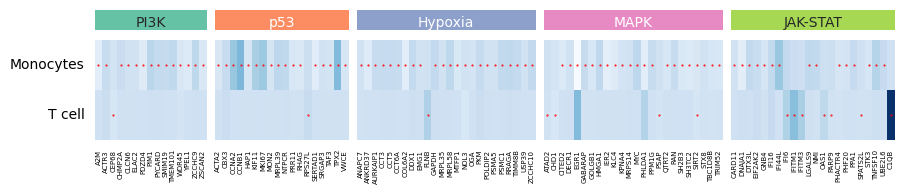

In [254]:
import marsilea as ma
import marsilea.plotter as mp

h = ma.Heatmap(top_sig_results[['log2FoldChange_tcell', 'log2FoldChange_monocyte']].fillna(0).T, 
                cmap="Blues", width=8, height=1, name="h1")

h.vsplit(labels=top_sig_results['source'],
          order=top_sig_results['source'].unique())

group_labels = mp.Chunk(list(top_sig_results['source'].unique()),
                        sns.color_palette("Set2").as_hex()[:len(top_sig_results['source'].unique())])

h.add_top(group_labels, size=.2, pad=.1)


celltype_labels = ma.plotter.Labels(['Monocytes', 'T cell'])
h.add_left(celltype_labels, size=.2, pad=.1)

target_names = ma.plotter.Labels(top_sig_results.index, size=5)
h.add_bottom(target_names, size=0.1, pad=.1)

sig_df = top_sig_results[['padj_tcell', 'padj_monocyte']].fillna(1)
layer1 = mp.MarkerMesh(sig_df.T.values <=0.05, color='Red', marker='.', label="Significant", size=1)
h.add_layer(layer1, name='Significance')

h.render()